# Car Dataset

In [29]:
# Import packages
from Bias import BIASme
from Transformations import remove_outliers_lof, trafo_ica
from DensityEstimators import DE_histogram, DE_kde
from IMITATE import IMITATE
from sklearn import model_selection
from sklearn import svm
from scipy import stats
from sklearn import tree
import pandas as pd
import numpy as np
import copy
import warnings
warnings.filterwarnings('ignore')

In [13]:
def loadData_car(dataset_size=1728):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
    toNum = {
        'low': 1,
        'med': 2,
        'high': 3,
        'vhigh':4,
        '5more':5,
        'more':5,
        'small':1,
        'big':3
    }
    dataset = pd.read_csv(url, header=None)
    y = dataset[6].to_numpy()
    dataset = dataset.drop([6], axis=1)
    dataset = dataset.replace({0:toNum, 1:toNum, 2:toNum, 3:toNum, 4:toNum, 5:toNum})
    dataset = dataset.apply(pd.to_numeric)
    
    isInB = np.array([dataset.to_numpy()[i,3]>3 for i in range(len(dataset))])
    isInB = isInB.reshape(len(isInB), 1)
    #dataset = dataset.drop([3], axis=1)
    X = np.append(dataset.to_numpy(), isInB, axis=1)
    
    return X, y

[Text(167.4, 163.07999999999998, 'X[3] <= 3.0\ngini = 0.457\nsamples = 1728\nvalue = [384, 69, 1210, 65]'),
 Text(83.7, 54.360000000000014, 'gini = 0.0\nsamples = 576\nvalue = [0, 0, 576, 0]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.579\nsamples = 1152\nvalue = [384, 69, 634, 65]')]

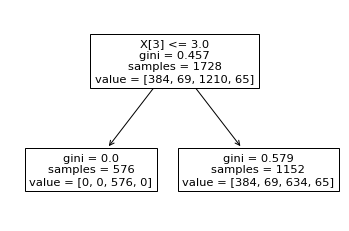

In [14]:
# quick check for the most predictive attribute:
from sklearn import tree
X, y = loadData_car()
clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(X[:,0:len(X[0])-1],y)
tree.plot_tree(clf)

In [3]:
# remove all mushrooms with rings <= 8
def bias_car(data, labels):
    isInB = data[:,-1]
    X = data[isInB==1]
    X = X[:, 0:(len(data[0])-1)]
    y = labels[isInB==1]
    return X, y

## INCOMPLETE case: we use one attribute for the bias but still keep it as an attribute

In [4]:
def run_and_eval(model, runs=10):
    acc_init = np.zeros(runs)
    acc_final = np.zeros(runs)
    hist_bins = list(range(10,30,3))
    
    for r in range(runs):
        bh = run_experiment(hist_bins, model=model, repeat=2)
        acc_init[r] = bh.D.acc_unbiased - bh.D.acc_init
        acc_final[r] = bh.D.acc_unbiased - bh.D.accuracyBiased(bh.added_points, bh.added_labels)
        print("run", r, "- acc_i =", acc_init[r], " acc_f =", acc_final[r])

    return acc_init, acc_final

In [5]:
def run_experiment(num_bins, model, repeat=10):
    DE = DE_histogram
    data_gen = loadData_car
    bias_gen = bias_car
    bh = IMITATE([10], bias_gen, data_gen, repeat=1, DE=DE, trafo=trafo_ica, model=model)
    
    # run 10 times, pick the result with the highest confidence
    max_conf = 0
    for bins in num_bins:
        for i in range(repeat):
            bh.reset()
            label_conf = bh.fill_up(num_bins=bins, iterations=10, fill_up_plots=False, point_plots=False, RO=True)
            #print("run", i, ", conf", label_conf)
            if max(label_conf) >= max_conf:
                max_conf = max(label_conf)
                best_bh = copy.deepcopy(bh)
    return best_bh

### Linear SVM

In [14]:
model = svm.SVC(kernel='linear')
res = run_and_eval(model)

run 0 - acc_i = 0.1483622350674374  acc_f = 0.1502890173410405
run 1 - acc_i = 0.13294797687861282  acc_f = 0.1368015414258189
run 2 - acc_i = 0.09633911368015424  acc_f = 0.12331406551059731
run 3 - acc_i = 0.1445086705202312  acc_f = 0.1560693641618497
run 4 - acc_i = 0.1271676300578034  acc_f = 0.140655105973025
run 5 - acc_i = 0.13102119460500972  acc_f = 0.13102119460500972
run 6 - acc_i = 0.1445086705202312  acc_f = 0.1502890173410405
run 7 - acc_i = 0.09441233140655103  acc_f = 0.07707129094412324
run 8 - acc_i = 0.11560693641618491  acc_f = 0.11946050096339111
run 9 - acc_i = 0.1560693641618497  acc_f = 0.18689788053949896


In [15]:
np.average(res, axis=1)

array([0.12909441, 0.1371869 ])

In [53]:
stats.ttest_ind(res[0], res[1])

Ttest_indResult(statistic=-0.719166836160424, pvalue=0.4812713750030476)

### Decision Tree

In [17]:
model = tree.DecisionTreeClassifier
res_tree = run_and_eval(model=model)

run 0 - acc_i = 0.1579961464354528  acc_f = 0.19460500963391136
run 1 - acc_i = 0.1252408477842003  acc_f = 0.1310211946050096
run 2 - acc_i = 0.10789980732177262  acc_f = 0.12331406551059731
run 3 - acc_i = 0.11946050096339111  acc_f = 0.138728323699422
run 4 - acc_i = 0.11368015414258192  acc_f = 0.11175337186897882
run 5 - acc_i = 0.10789980732177262  acc_f = 0.12909441233140662
run 6 - acc_i = 0.1348747591522158  acc_f = 0.1522157996146435
run 7 - acc_i = 0.1522157996146435  acc_f = 0.1387283236994219
run 8 - acc_i = 0.20423892100192675  acc_f = 0.16955684007707128
run 9 - acc_i = 0.10597302504816963  acc_f = 0.12138728323699421


In [18]:
np.average(res_tree, axis=1)

array([0.13294798, 0.14104046])

In [19]:
stats.ttest_ind(res_tree[0], res_tree[1])

Ttest_indResult(statistic=-0.642022067886078, pvalue=0.5289513369038473)

### SVM with RBF kernel

In [20]:
model = svm.SVC(kernel='rbf')
res_rbf = run_and_eval(model=model)

run 0 - acc_i = 0.1387283236994219  acc_f = 0.1502890173410404
run 1 - acc_i = 0.10982658959537572  acc_f = 0.10019267822736033
run 2 - acc_i = 0.138728323699422  acc_f = 0.1425818882466282
run 3 - acc_i = 0.17726396917148368  acc_f = 0.19267822736030826
run 4 - acc_i = 0.1252408477842003  acc_f = 0.1541425818882466
run 5 - acc_i = 0.1483622350674374  acc_f = 0.16570327552986508
run 6 - acc_i = 0.1541425818882466  acc_f = 0.1329479768786127
run 7 - acc_i = 0.09441233140655114  acc_f = 0.10404624277456653
run 8 - acc_i = 0.13102119460500972  acc_f = 0.1368015414258189
run 9 - acc_i = 0.1329479768786127  acc_f = 0.1348747591522158


In [21]:
np.average(res_rbf, axis=1)

array([0.13506744, 0.14142582])

In [22]:
stats.ttest_ind(res_rbf[0], res_rbf[1])

Ttest_indResult(statistic=-0.5638028970684485, pvalue=0.5798455867111438)

## Why doesn't it work well?

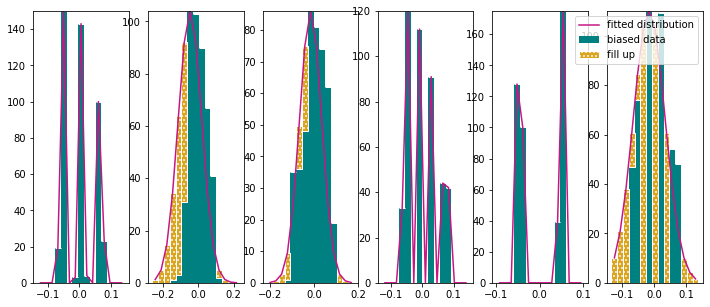

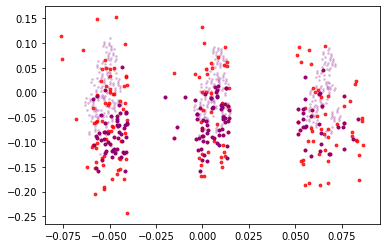

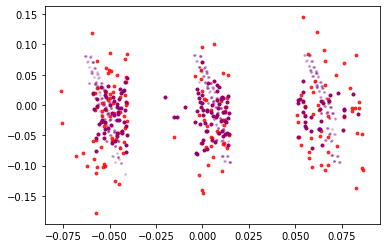

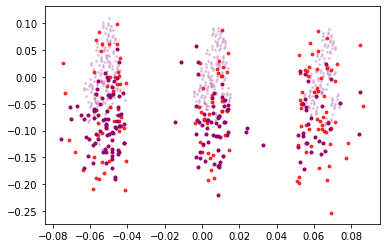

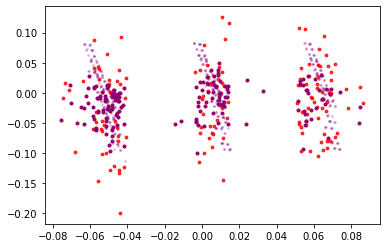

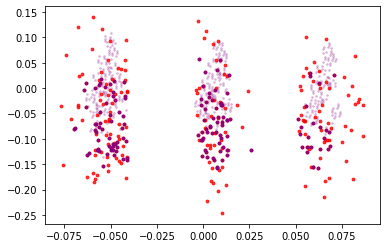

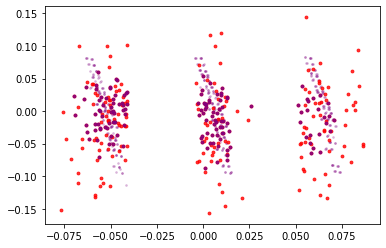

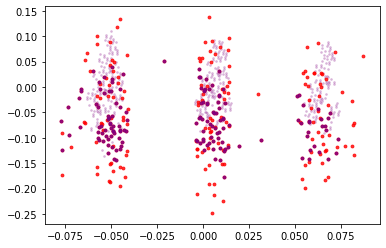

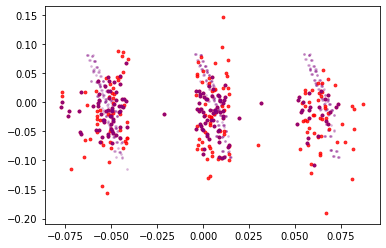

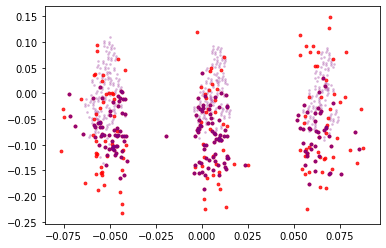

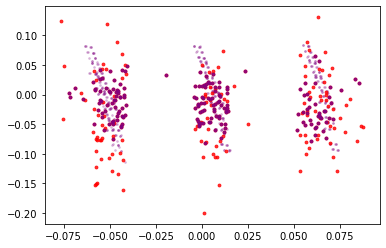

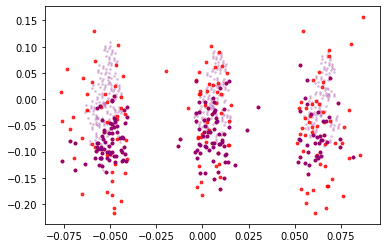

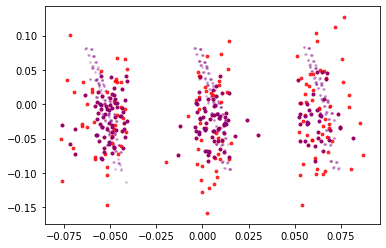

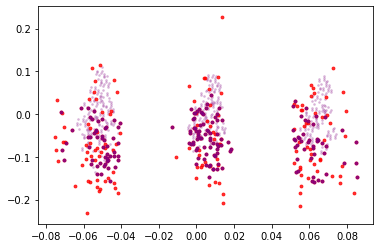

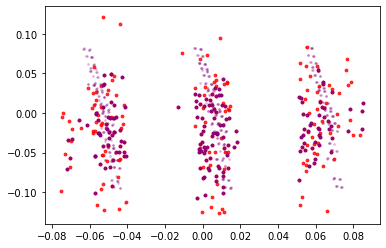

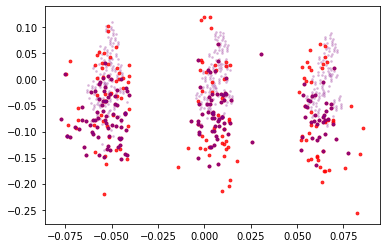

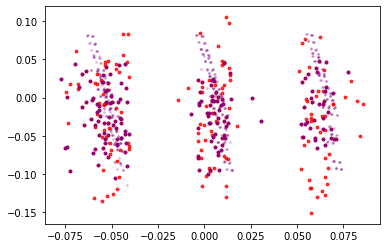

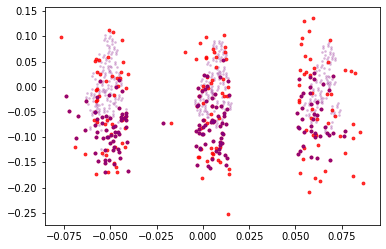

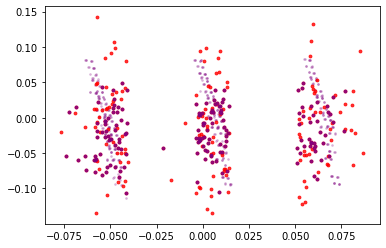

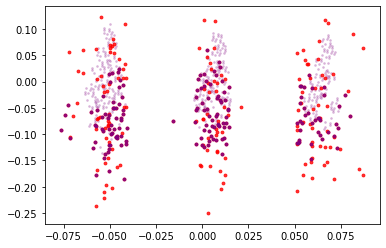

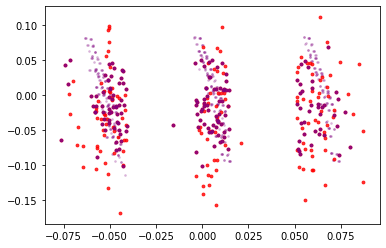

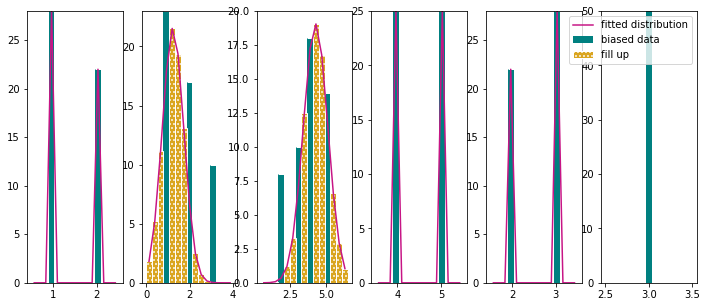

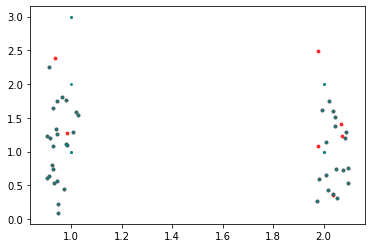

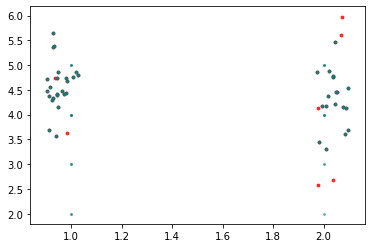

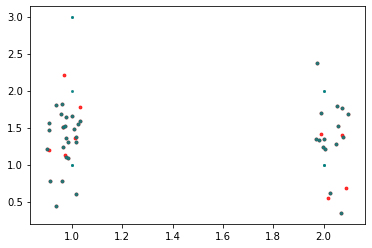

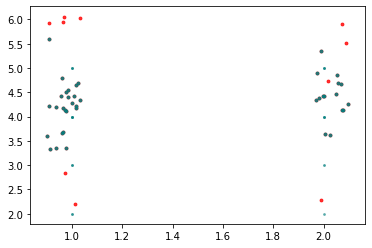

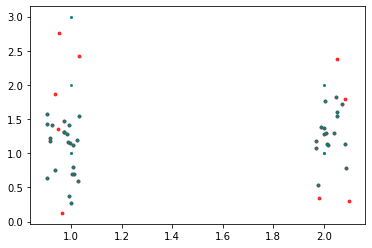

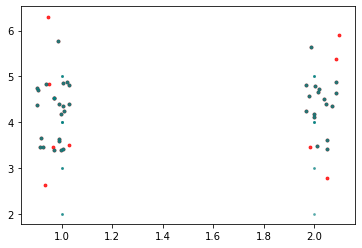

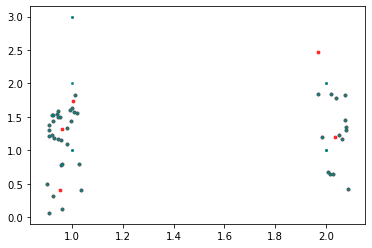

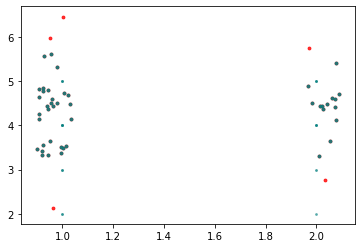

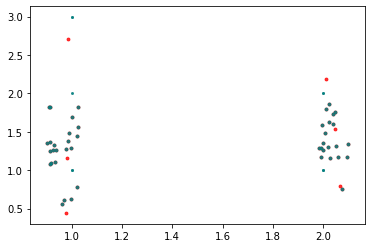

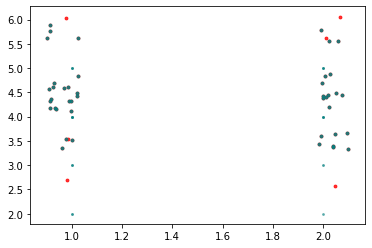

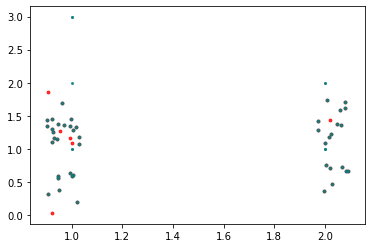

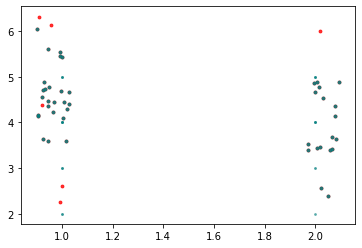

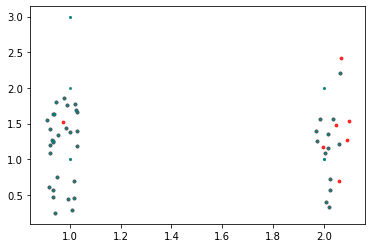

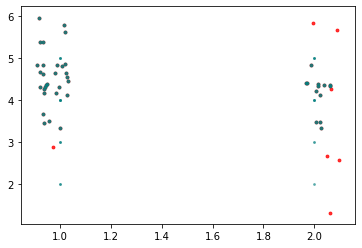

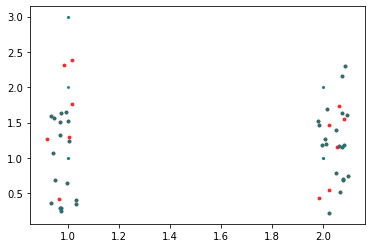

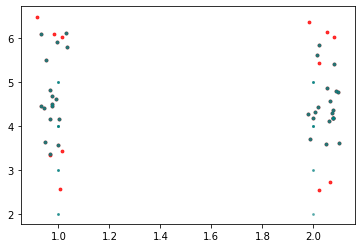

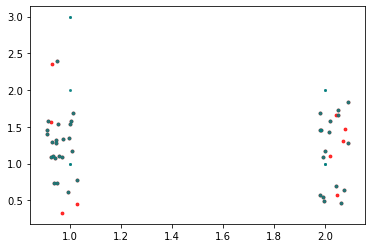

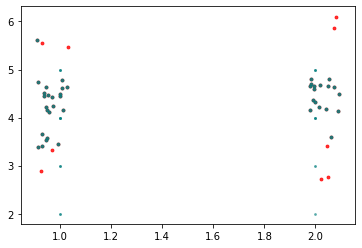

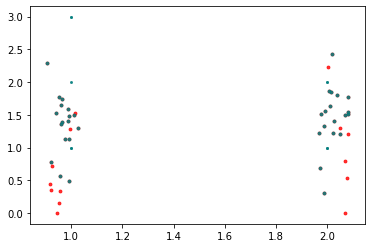

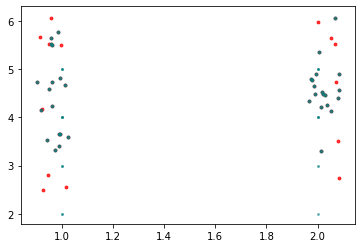

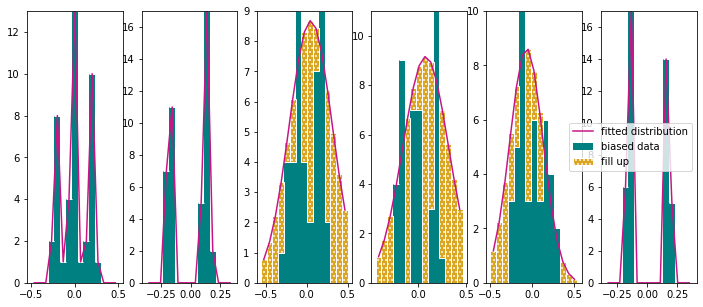

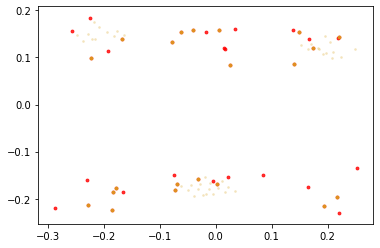

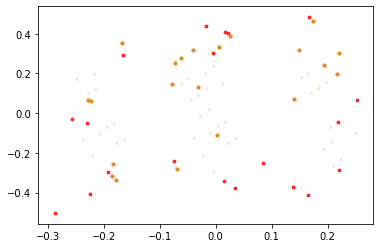

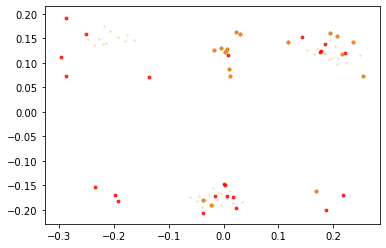

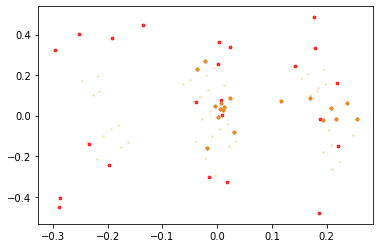

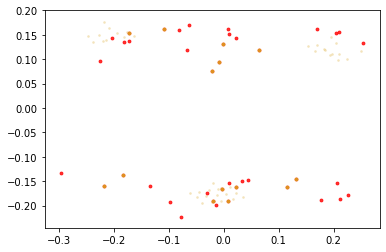

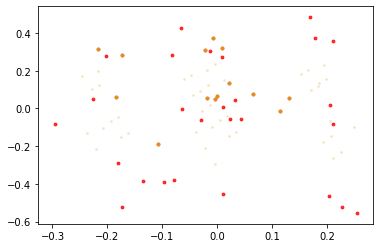

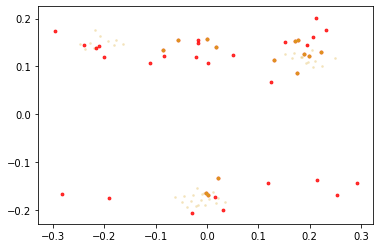

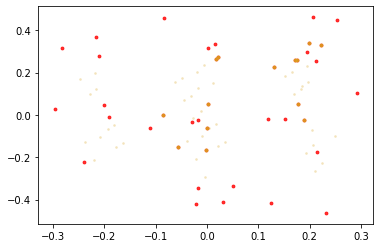

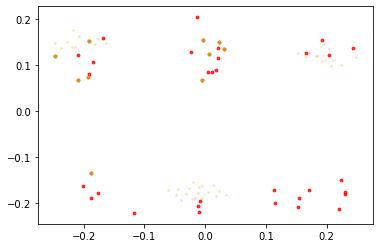

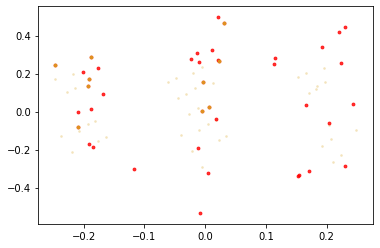

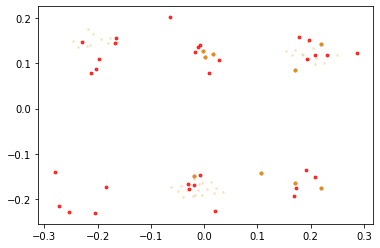

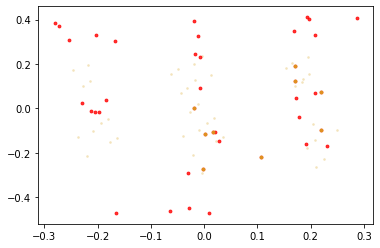

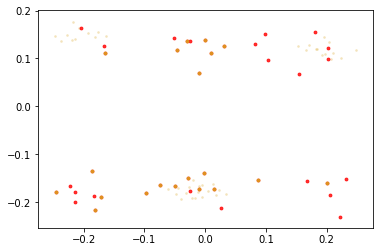

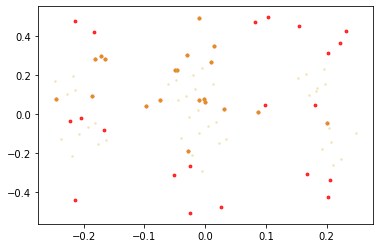

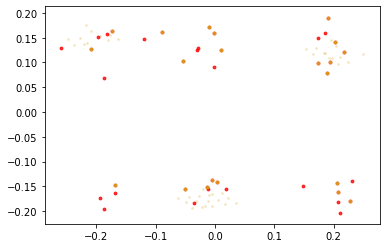

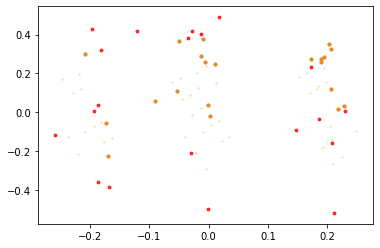

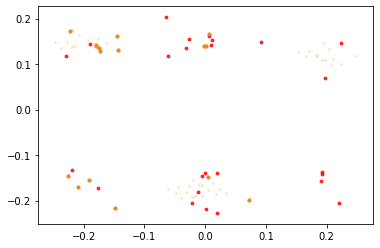

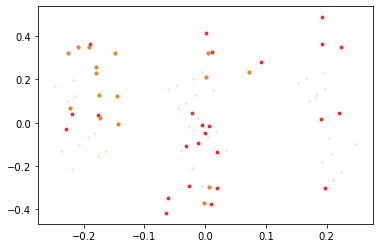

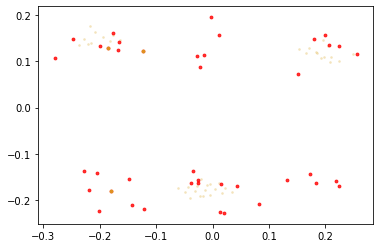

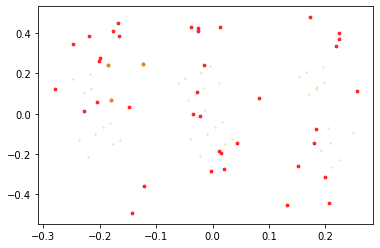

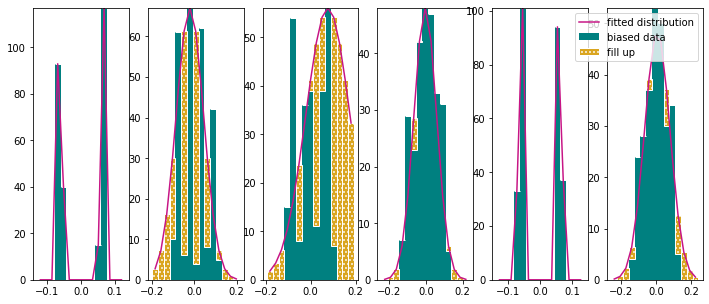

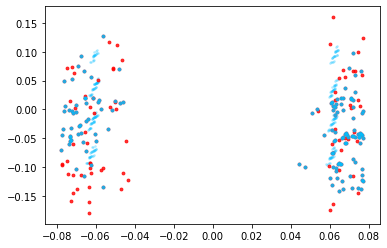

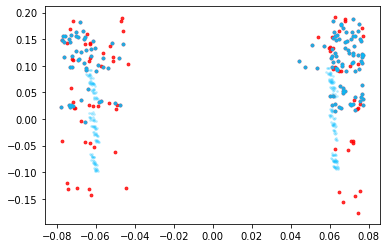

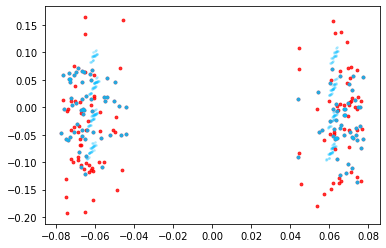

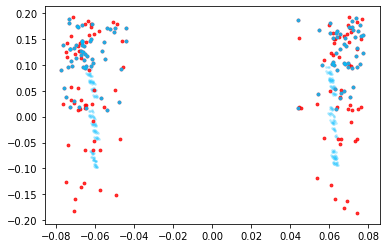

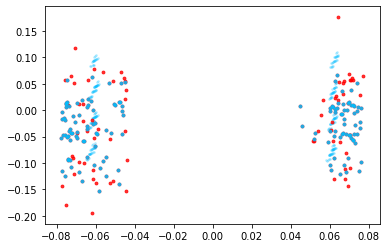

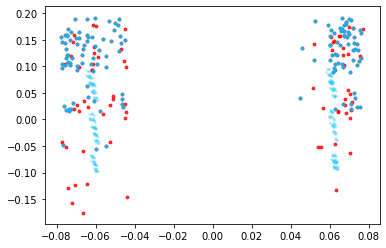

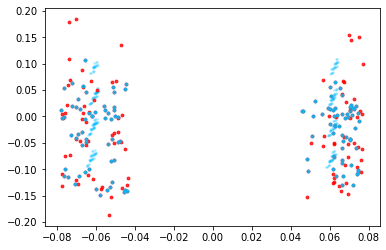

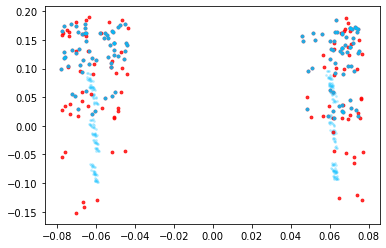

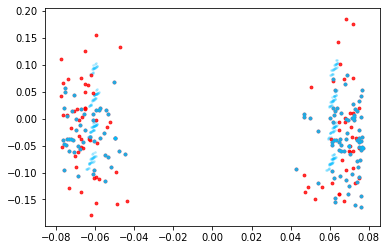

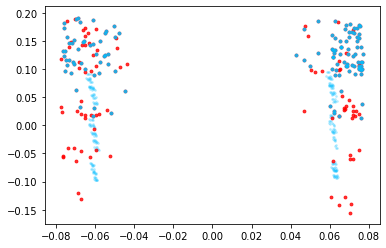

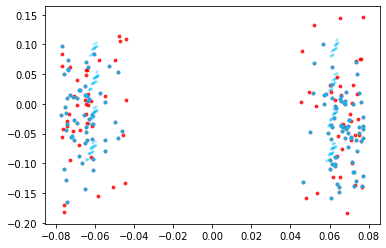

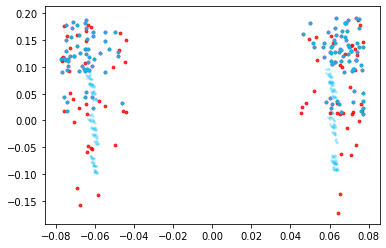

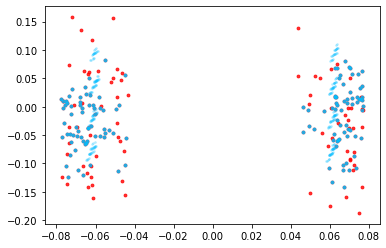

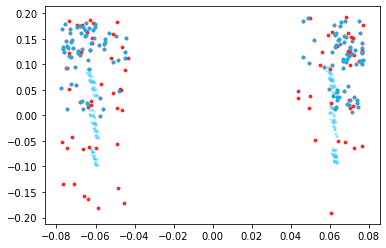

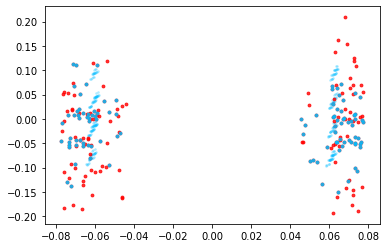

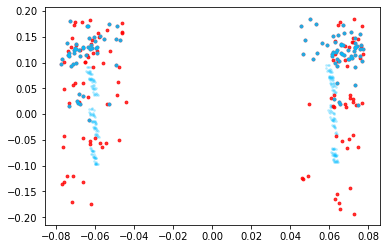

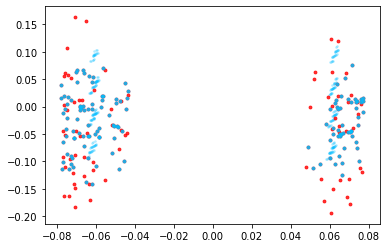

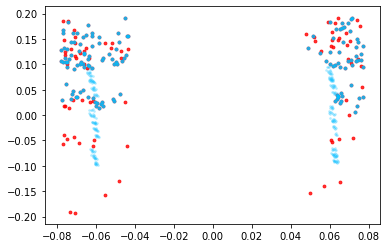

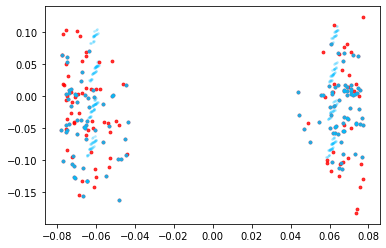

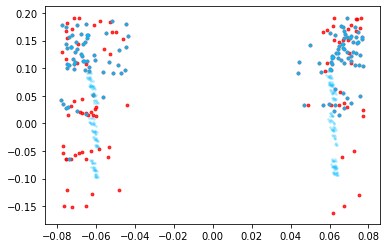

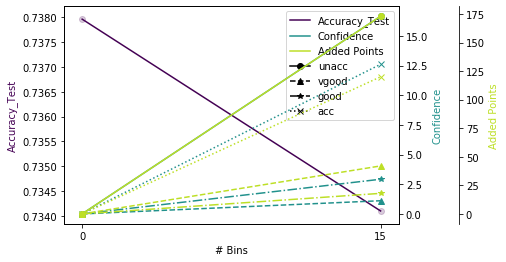

In [23]:
data_gen = loadData_car
bias_gen = bias_car
DE = DE_histogram
bh = IMITATE([15], bias_gen, data_gen, repeat=1, DE=DE, trafo=trafo_ica)
bh.run(True, True, False)

We have discrete features in the dataset....